In [ ]:
# Imports
import os
import re
import copy
import numpy as np
import pdfplumber
import pandas as pd
import nltk
import openai
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
pdf_dir = "./data"
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
title_abstract_list = []
print(pdf_files)

# testDir="./data/doc16.pdf"

# print(extract_title_abstract(testDir)[0])

In [ ]:
def extract_title_abstract(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[0]

        text = page.extract_text(x_tolerance=1, y_tolerance=5)

        # print(page.chars)
        table={}
        for x,i in enumerate(page.chars):
            # print(i["text"])
            # if i["text"]==" " or i["text"]=="\n":
            #     print("new line")
            if i["size"] not in table:
                table[i["size"]]=""
            if x>0 and i["x0"]-page.chars[x-1]["x1"]>=1:
                table[i["size"]]+=" "
            if x>0 and page.chars[x-1]["y1"]-i["y1"]>5:
                table[i["size"]]+=" "
            table[i["size"]]+=i["text"]


        # print(text,"\n") 
        tmp=copy.deepcopy(table)

        for i in tmp:
            if len(tmp[i])<30:
                del table[i]

        title=table[max(table.keys())].strip().replace("  "," ")
        abstract_match = re.search(r"Abstract\s+(.*?[.!?])\s*\n[c,©]", text, re.DOTALL)
        if not abstract_match:
            abstract_match = re.search(r'(?i)abstract\b\.?:?]?\s+((?:.|\n)+?)(?=\n\d+\.|Key|Introduction|[0,1]?\Z)', text, re.DOTALL)

        if abstract_match:
            abstract = abstract_match.group(1).strip()

    if not abstract_match:
        abstract = "No abstract found"
    # abstract = text.split('\n')
    # print("Title: ",title,"Abstract: ",abstract)
    # print(title, "\n")

    return title, abstract

# 1B

In [ ]:


def get_text_from_pdf(pdf_path):
    allText=""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
             allText+=page.extract_text(x_tolerance=1, y_tolerance=5)
    return allText

lemmatizer=WordNetLemmatizer()


def preprocess_text(text):
    words=word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered= [lemmatizer.lemmatize(w.lower()) for w in words if not w in stop_words and w.isalpha()]
    return filtered


In [ ]:
embeddings={}

def get_embedding(text, model="text-embedding-ada-002"):
   return openai.Embedding.create(input = text, model=model)['data'][0]['embedding']

for i in pdf_files:
    text=get_text_from_pdf("./data/"+i)
    filtered=" ".join(preprocess_text(text))
    if len(filtered)>8192:
        filtered=filtered[:8192]
    embeddings[i]=get_embedding(filtered)

    

In [ ]:
import random

random_indices = random.sample(range(len(pdf_files)), 5)
random_indices

In [ ]:
random_embeddings = np.array([embeddings[pdf_files[i]] for i in random_indices])
random_documents = [pdf_files[i] for i in random_indices]


In [397]:
for i,j in zip(random_documents,random_embeddings):
    # Exclude self-similarity by setting it to a negative value
    print('Most similar documents to Document', i, 'are:')
    table={}
    for k,l in embeddings.items():
        if k!=i:
            j=np.array(j).reshape(1,-1)
            l=np.array(l).reshape(1,-1)
            table[k]=cosine_similarity(j,l)
    table=sorted(table.items(), key=lambda x: x[1], reverse=True)
    for k in table[:3]:
        print("Document:",k[0],"Similarity:",k[1][0][0])


Most similar documents to Document doc29.pdf are:
Document: doc27.pdf Similarity: 0.9320175677156629
Document: doc25.pdf Similarity: 0.9227189878337612
Document: doc32.pdf Similarity: 0.9154422087966885
Most similar documents to Document doc1.pdf are:
Document: doc8.pdf Similarity: 0.9236904854393052
Document: doc2.pdf Similarity: 0.9170683402922537
Document: doc7.pdf Similarity: 0.9123949053781167
Most similar documents to Document doc13.pdf are:
Document: doc3.pdf Similarity: 0.9155922549226865
Document: doc10.pdf Similarity: 0.8760483984036801
Document: doc2.pdf Similarity: 0.8649225708450421
Most similar documents to Document doc26.pdf are:
Document: doc28.pdf Similarity: 0.9358299280592797
Document: doc27.pdf Similarity: 0.9071036577391068
Document: doc29.pdf Similarity: 0.9063512892748393
Most similar documents to Document doc30.pdf are:
Document: doc29.pdf Similarity: 0.8990406785658092
Document: doc27.pdf Similarity: 0.8980379702262712
Document: doc2.pdf Similarity: 0.894014319

Using Doc2Vec for Document Similarity

In [401]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec

In [406]:
docsSorted = sorted(pdf_files, key=lambda x: (int(x.split('doc')[1].split('.pdf')[0])))

dataD2V = []

for i in docsSorted:
    text=get_text_from_pdf("./data/"+i)
    dataD2V.append(" ".join(preprocess_text(text)))

dataD2VTagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(dataD2V)]

In [407]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
model.build_vocab(dataD2VTagged)
model.train(dataD2VTagged, total_examples=model.corpus_count, epochs=80)
model.save("DocsSimilarity.model")
model = Doc2Vec.load("DocsSimilarity.model")

In [413]:
docNum = 29  # Place a number to see which you want
similar_doc = model.dv.most_similar(str(docNum), topn=3)
print("Selected Document", docsSorted[docNum-1])
print("Array Featuring Three Most Similar Docs", similar_doc)
print("Names of Three Most Similar Documents:", docsSorted[int(similar_doc[0][0])-1] + "  " +
      docsSorted[int(similar_doc[1][0])-1] + "  " + docsSorted[int(similar_doc[2][0])-1])

Selected Document doc29.pdf
Array Featuring Three Most Similar Docs [('28', 0.4951625168323517), ('3', 0.36587247252464294), ('26', 0.34486547112464905)]
Names of Three Most Similar Documents: doc28.pdf  doc3.pdf  doc26.pdf


**QUESTION 3**

In [398]:
df=pd.DataFrame(embeddings.items(),columns=["file","embedding"])
df

file                                          embedding
0    doc1.pdf  [-0.010899050161242485, 0.009243933483958244, ...
1   doc10.pdf  [-0.011480467393994331, 0.007103709504008293, ...
2   doc11.pdf  [-0.02304147370159626, 0.011210854165256023, -...
3   doc12.pdf  [-0.016462575644254684, 0.006374605931341648, ...
4   doc13.pdf  [-0.0025639308150857687, 0.02657500095665455, ...
5   doc14.pdf  [-0.02174735628068447, 0.013653108850121498, -...
6   doc15.pdf  [-0.018582995980978012, -0.001294617773965001,...
7   doc16.pdf  [-0.010227430611848831, 0.0008377095218747854,...
8   doc17.pdf  [-0.028321940451860428, -0.0017381818033754826...
9   doc18.pdf  [-0.026384860277175903, 0.018750730901956558, ...
10  doc19.pdf  [-0.009195501916110516, 0.0120622543618083, 0....
11   doc2.pdf  [-0.008571387268602848, 0.02901911549270153, 0...
12  doc20.pdf  [-0.009554036892950535, 0.019585775211453438, ...
13  doc21.pdf  [-0.041522204875946045, -0.0015089752851054072...
14  doc22.pdf  [-0.0158598143607378, 0.008658858947455883, -0...
15  doc23.pdf  [-0.01831931620836258, 0.003805148648098111, 0...
16  doc24.pdf  [-0.008951050229370594, 0.01757032424211502, 0...
17  doc25.pdf  [-0.001941551105119288, 0.014999166131019592, ...
18  doc26.pdf  [0.004083622712641954, 0.018478306010365486, 0...
19  doc27.pdf  [0.001621745410375297, -0.002497762208804488, ...
20  doc28.pdf  [-0.0026065350975841284, 0.021661678329110146,...
21  doc29.pdf  [-0.015436634421348572, 0.006091786548495293, ...
22   doc3.pdf  [-0.010084398090839386, 0.021493149921298027, ...
23  doc30.pdf  [-0.0006533912383019924, 0.01647629775106907, ...
24  doc31.pdf  [0.004320502746850252, -0.0024500200524926186,...
25  doc32.pdf  [-0.013320758007466793, 0.015467069111764431, ...
26   doc4.pdf  [-0.01012486033141613, 0.019041404128074646, 0...
27   doc5.pdf  [-0.017176665365695953, 0.021092234179377556, ...
28   doc6.pdf  [-0.018870294094085693, 0.014768056571483612, ...
29   doc7.pdf  [-0.009010609239339828, 0.017658282071352005, ...
30   doc8.pdf  [-0.026737811043858528, 0.022522512823343277, ...
31   doc9.pdf  [-0.021898191422224045, 0.011515905149281025, ...

In [399]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

matrix=np.array(list(embeddings.values()))
scaled=StandardScaler().fit_transform(matrix)


pca=PCA(n_components=2)

reduced=pca.fit_transform(scaled)
df["reduced2D"]=reduced.tolist()

pca=PCA(n_components=30)

reduced30=pca.fit_transform(scaled)
df["reduced30D"]=reduced30.tolist()

In [400]:
df

file                                          embedding  \
0    doc1.pdf  [-0.010899050161242485, 0.009243933483958244, ...   
1   doc10.pdf  [-0.011480467393994331, 0.007103709504008293, ...   
2   doc11.pdf  [-0.02304147370159626, 0.011210854165256023, -...   
3   doc12.pdf  [-0.016462575644254684, 0.006374605931341648, ...   
4   doc13.pdf  [-0.0025639308150857687, 0.02657500095665455, ...   
5   doc14.pdf  [-0.02174735628068447, 0.013653108850121498, -...   
6   doc15.pdf  [-0.018582995980978012, -0.001294617773965001,...   
7   doc16.pdf  [-0.010227430611848831, 0.0008377095218747854,...   
8   doc17.pdf  [-0.028321940451860428, -0.0017381818033754826...   
9   doc18.pdf  [-0.026384860277175903, 0.018750730901956558, ...   
10  doc19.pdf  [-0.009195501916110516, 0.0120622543618083, 0....   
11   doc2.pdf  [-0.008571387268602848, 0.02901911549270153, 0...   
12  doc20.pdf  [-0.009554036892950535, 0.019585775211453438, ...   
13  doc21.pdf  [-0.041522204875946045, -0.0015089752851054072...   
14  doc22.pdf  [-0.0158598143607378, 0.008658858947455883, -0...   
15  doc23.pdf  [-0.01831931620836258, 0.003805148648098111, 0...   
16  doc24.pdf  [-0.008951050229370594, 0.01757032424211502, 0...   
17  doc25.pdf  [-0.001941551105119288, 0.014999166131019592, ...   
18  doc26.pdf  [0.004083622712641954, 0.018478306010365486, 0...   
19  doc27.pdf  [0.001621745410375297, -0.002497762208804488, ...   
20  doc28.pdf  [-0.0026065350975841284, 0.021661678329110146,...   
21  doc29.pdf  [-0.015436634421348572, 0.006091786548495293, ...   
22   doc3.pdf  [-0.010084398090839386, 0.021493149921298027, ...   
23  doc30.pdf  [-0.0006533912383019924, 0.01647629775106907, ...   
24  doc31.pdf  [0.004320502746850252, -0.0024500200524926186,...   
25  doc32.pdf  [-0.013320758007466793, 0.015467069111764431, ...   
26   doc4.pdf  [-0.01012486033141613, 0.019041404128074646, 0...   
27   doc5.pdf  [-0.017176665365695953, 0.021092234179377556, ...   
28   doc6.pdf  [-0.018870294094085693, 0.014768056571483612, ...   
29   doc7.pdf  [-0.009010609239339828, 0.017658282071352005, ...   
30   doc8.pdf  [-0.026737811043858528, 0.022522512823343277, ...   
31   doc9.pdf  [-0.021898191422224045, 0.011515905149281025, ...   

                                      reduced2D  \
0      [12.240310442084972, 2.4284760784235675]   
1     [-16.11777803390841, -16.160335200288515]   
2     [-13.80870219615075, -13.549171021740417]   
3    [-16.317142802177024, -15.781905150788138]   
4     [-2.9707894934289403, -19.63411408968404]   
5      [-6.191437444028021, -8.484505062667225]   
6    [-15.043561862544685, -13.275857068103418]   
7    [-15.809475775788913, -14.370220071881224]   
8      [-13.785348941401933, 0.456483540931684]   
9   [-0.11807622347897649, -0.9798356002786537]   
10      [14.060875623150915, 5.468704520364182]   
11    [-0.8917439184365552, 3.4006531772181354]   
12     [20.770261469979772, -4.110154660113309]   
13     [-7.516575674879871, -4.374808780547875]   
14     [20.150798902302242, -7.019484534319424]   
15      [17.02239566571614, -3.662321511473151]   
16     [1.9881867690034956, -4.214796652716302]   
17     [-7.598642785287978, 16.721752518019535]   
18    [-0.7535684190764957, 16.243043513614456]   
19    [-12.404616228556975, 19.337323703370583]   
20     [1.7605763356268178, 15.228566672162149]   
21     [-9.759017703105267, 20.762411287249744]   
22    [11.329440717351135, -11.984106022030456]   
23    [-15.500532815263448, 16.964483131920467]   
24    [-13.075993588780555, 20.793528958523613]   
25    [0.43095045609715216, 20.036580067926256]   
26   [12.276224530726278, -0.39888607036784407]   
27      [7.611289642064435, -5.133996837366147]   
28    [23.724104442084847, -1.3692617157419111]   
29     [18.29016965248977, -1.2825375200421114]   
30     [21.717601630986902, 1.3866036795881889]   
31    [-15.710182373370088, -13.44231327916239]   

                                           reduced30D  
0   [12.240562065263003,

/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

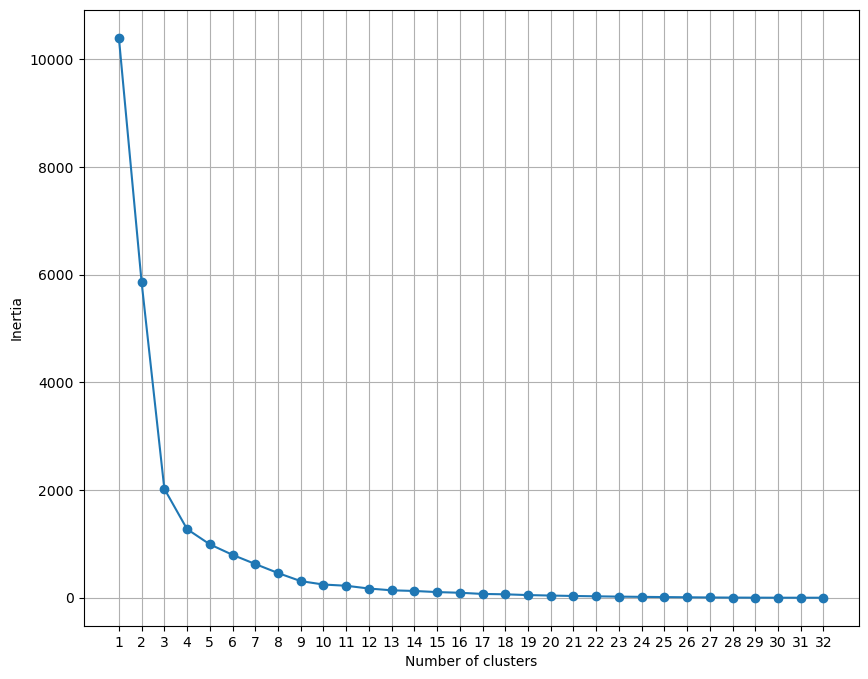

In [402]:
from sklearn.cluster import KMeans
intertia=[]


for i in range(1,33):
    KM=KMeans(n_clusters=i).fit(reduced)
    intertia.append(KM.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,33),intertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,33))
plt.grid(True)
plt.show()

In [414]:
clustering=KMeans(n_clusters=4).fit(df["reduced30D"].tolist())
centroids = clustering.cluster_centers_
df["cluster"]=clustering.labels_
df

/home/verse/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


file                                          embedding  \
0    doc1.pdf  [-0.010899050161242485, 0.009243933483958244, ...   
1   doc10.pdf  [-0.011480467393994331, 0.007103709504008293, ...   
2   doc11.pdf  [-0.02304147370159626, 0.011210854165256023, -...   
3   doc12.pdf  [-0.016462575644254684, 0.006374605931341648, ...   
4   doc13.pdf  [-0.0025639308150857687, 0.02657500095665455, ...   
5   doc14.pdf  [-0.02174735628068447, 0.013653108850121498, -...   
6   doc15.pdf  [-0.018582995980978012, -0.001294617773965001,...   
7   doc16.pdf  [-0.010227430611848831, 0.0008377095218747854,...   
8   doc17.pdf  [-0.028321940451860428, -0.0017381818033754826...   
9   doc18.pdf  [-0.026384860277175903, 0.018750730901956558, ...   
10  doc19.pdf  [-0.009195501916110516, 0.0120622543618083, 0....   
11   doc2.pdf  [-0.008571387268602848, 0.02901911549270153, 0...   
12  doc20.pdf  [-0.009554036892950535, 0.019585775211453438, ...   
13  doc21.pdf  [-0.041522204875946045, -0.0015089752851054072...   
14  doc22.pdf  [-0.0158598143607378, 0.008658858947455883, -0...   
15  doc23.pdf  [-0.01831931620836258, 0.003805148648098111, 0...   
16  doc24.pdf  [-0.008951050229370594, 0.01757032424211502, 0...   
17  doc25.pdf  [-0.001941551105119288, 0.014999166131019592, ...   
18  doc26.pdf  [0.004083622712641954, 0.018478306010365486, 0...   
19  doc27.pdf  [0.001621745410375297, -0.002497762208804488, ...   
20  doc28.pdf  [-0.0026065350975841284, 0.021661678329110146,...   
21  doc29.pdf  [-0.015436634421348572, 0.006091786548495293, ...   
22   doc3.pdf  [-0.010084398090839386, 0.021493149921298027, ...   
23  doc30.pdf  [-0.0006533912383019924, 0.01647629775106907, ...   
24  doc31.pdf  [0.004320502746850252, -0.0024500200524926186,...   
25  doc32.pdf  [-0.013320758007466793, 0.015467069111764431, ...   
26   doc4.pdf  [-0.01012486033141613, 0.019041404128074646, 0...   
27   doc5.pdf  [-0.017176665365695953, 0.021092234179377556, ...   
28   doc6.pdf  [-0.018870294094085693, 0.014768056571483612, ...   
29   doc7.pdf  [-0.009010609239339828, 0.017658282071352005, ...   
30   doc8.pdf  [-0.026737811043858528, 0.022522512823343277, ...   
31   doc9.pdf  [-0.021898191422224045, 0.011515905149281025, ...   

                                      reduced2D  \
0      [12.240310442084972, 2.4284760784235675]   
1     [-16.11777803390841, -16.160335200288515]   
2     [-13.80870219615075, -13.549171021740417]   
3    [-16.317142802177024, -15.781905150788138]   
4     [-2.9707894934289403, -19.63411408968404]   
5      [-6.191437444028021, -8.484505062667225]   
6    [-15.043561862544685, -13.275857068103418]   
7    [-15.809475775788913, -14.370220071881224]   
8      [-13.785348941401933, 0.456483540931684]   
9   [-0.11807622347897649, -0.9798356002786537]   
10      [14.060875623150915, 5.468704520364182]   
11    [-0.8917439184365552, 3.4006531772181354]   
12     [20.770261469979772, -4.110154660113309]   
13     [-7.516575674879871, -4.374808780547875]   
14     [20.150798902302242, -7.019484534319424]   
15      [17.02239566571614, -3.662321511473151]   
16     [1.9881867690034956, -4.214796652716302]   
17     [-7.598642785287978, 16.721752518019535]   
18    [-0.7535684190764957, 16.243043513614456]   
19    [-12.404616228556975, 19.337323703370583]   
20     [1.7605763356268178, 15.228566672162149]   
21     [-9.759017703105267, 20.762411287249744]   
22    [11.329440717351135, -11.984106022030456]   
23    [-15.500532815263448, 16.964483131920467]   
24    [-13.075993588780555, 20.793528958523613]   
25    [0.43095045609715216, 20.036580067926256]   
26   [12.276224530726278, -0.39888607036784407]   
27      [7.611289642064435, -5.133996837366147]   
28    [23.724104442084847, -1.3692617157419111]   
29     [18.29016965248977, -1.2825375200421114]   
30     [21.717601630986902, 1.3866036795881889]   
31    [-15.710182373370088, -13.44231327916239]   

                                           reduced30D  cluster  
0   [12.2405620

In [434]:
df.iloc[23]['cluster']

2

In [443]:
from scipy.spatial import distance
cluster_info = pd.DataFrame(columns=['Cluster number', 'Representative documents'])
clustered={}
for i, centroid in enumerate(centroids):
    distances = distance.cdist([centroid], df['reduced30D'].tolist(), 'euclidean')[0]
    closest_indices = distances.argsort()  # Get indices of 3 closest documents
    # print(closest_indices)
    representatives = []
    count=0
    j=0
    while(count!=3 or j!=len(closest_indices)):
        if df.iloc[closest_indices[i]]['cluster']==closest_indices[i]:
            representatives.append(df['file'][i])
            representative_docs = " | ".join(representatives)  # Join the title+abstract strings
            cluster_info = cluster_info.append({'Cluster number': i, 'Representative documents': representative_docs}, ignore_index=True)
            count+=1
            print("Cluster",i,"Representative Documents:",representative_docs)
        j+=1
    

Cluster 0 Representative Documents: doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf | doc1.pdf
Cluster 0 Representative Documents: doc1.pdf | doc1.pdf

In [405]:
cluster_info

Cluster number           Representative documents
0              0  doc27.pdf | doc29.pdf | doc28.pdf
1              1  doc10.pdf | doc12.pdf | doc14.pdf
2              2    doc24.pdf | doc4.pdf | doc1.pdf
3              3    doc23.pdf | doc7.pdf | doc1.pdf

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clustering.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=80, label='Centroids')
plt.legend()
# plt.colorbar(label='Cluster Label')
# plt.scatter(reduced[:,0],reduced[:,1],c=clustering2.labels_)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(reduced, method='ward') 

plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1,33),distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,33))
plt.grid(True)
plt.show()

In [ ]:
print(intertia)

# TF-IDF_vector)